# MOONS - Project

A special sample of galaxies will be generated taking into account the galaxy-type and varying the parameters passed to the SFH module in order to mimic the behavior of an Early-Type, A Spiral Diskr and a Starburst galaxy. 

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pcigale import sed
from pcigale import sed_modules as modules
from copy import deepcopy
from astropy.table import Table

In [2]:
%pylab inline
%config InlineBackend.figure_format='svg'
matplotlib.rcParams['figure.figsize'] = [11.,5.]

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Function defined in order to cut the spectrum in a given range

def limit_spec(spectrum):
    wave, lum = spectrum
    xmin, xmax = 100, 681 #This cut corresponds to ELODIE models
    mask = (wave >= xmin) & (wave <= xmax)
    return wave[mask], lum[mask]

# SED Objects are initialized

I need to create two SED objects per galaxy in order to apply BC03 model and use emission lines or M011 model and use high-resolution in the continuum

In [64]:
gal_1     = sed.SED()
gal_2     = sed.SED()
gal_3     = sed.SED()

In [65]:
# SFH module is applied

mod_1 = modules.get_module('sfhdelayed', tau_main=1000, age_main=5000, f_burst=0.0)
mod_1.process(gal_1)

mod_2 = modules.get_module('sfhdelayed', tau_main=3000, age_main=5000, age_burst=500, tau_burst=1e4, f_burst=0.1)
mod_2.process(gal_2)

mod_3 = modules.get_module('sfhdelayed', tau_main=6000, age_main=5000, age_burst=50, tau_burst=1e4, f_burst=0.1)
mod_3.process(gal_3)

# SSP module is applied

# The high-resolution model of G. Bruzual and S. Charlot, 2003 is used
# mod_1   = modules.get_module('bc03', imf = 0, metallicity = 0.02)
# mod_1.process(gal_1)
# star_emission_1 = gal_1.wavelength_grid, gal_1.fnu

# mod_2   = modules.get_module('bc03', imf = 0, metallicity = 0.02)
# mod_2.process(gal_2)
# star_emission_2 = gal_2.wavelength_grid, gal_2.fnu

# mod_3   = modules.get_module('bc03', imf = 0, metallicity = 0.02)
# mod_3.process(gal_3)
# star_emission_3 = gal_3.wavelength_grid, gal_3.fnu


# The high-resolution model of C. Maraston and G. Strömbäck, 2011 is used
mod_1   = modules.get_module('m2005', imf = 0, metallicity = 0.02)
mod_1.process(gal_1)
star_emission_1 = gal_1.wavelength_grid, gal_1.fnu

mod_2   = modules.get_module('m2005', imf = 0, metallicity = 0.02)
mod_2.process(gal_2)
star_emission_2 = gal_2.wavelength_grid, gal_2.fnu

mod_3   = modules.get_module('m2005', imf = 0, metallicity = 0.02)
mod_3.process(gal_3)
star_emission_3 = gal_3.wavelength_grid, gal_3.fnu

# Dust Attenuation

mod_1 = modules.get_module('dustatt_modified_CF00', Av_ISM = 0.5, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_1.process(gal_1)
attenuated_star_emission_1 = gal_1.wavelength_grid, gal_1.fnu

mod_2 = modules.get_module('dustatt_modified_CF00', Av_ISM = 0.5, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_2.process(gal_2)
attenuated_star_emission_2 = gal_2.wavelength_grid, gal_2.fnu

mod_3 = modules.get_module('dustatt_modified_CF00', Av_ISM = 0.5, mu = 0.3, slope_ISM = -0.7, slope_BC = -0.7)
mod_3.process(gal_3)
attenuated_star_emission_3 = gal_3.wavelength_grid, gal_3.fnu

# Dust Emission

mod_1 = modules.get_module('dl2014', alpha=2.5)
mod_1.process(gal_1)
attenuated_star_emission_with_ir_1   = gal_1.wavelength_grid, gal_1.fnu

mod_2 = modules.get_module('dl2014', alpha=2.5)
mod_2.process(gal_2)
attenuated_star_emission_with_ir_2   = gal_2.wavelength_grid, gal_2.fnu

mod_3 = modules.get_module('dl2014', alpha=2.5)
mod_3.process(gal_3)
attenuated_star_emission_with_ir_3   = gal_3.wavelength_grid, gal_3.fnu

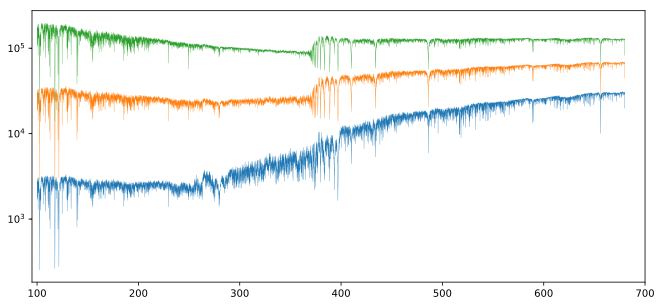

In [66]:
plt.plot(*star_emission_1, lw = '0.3')
plt.plot(*star_emission_2, lw = '0.3')
plt.plot(*star_emission_3, lw = '0.3')
plt.xlim(95, 700)
plt.yscale('symlog')

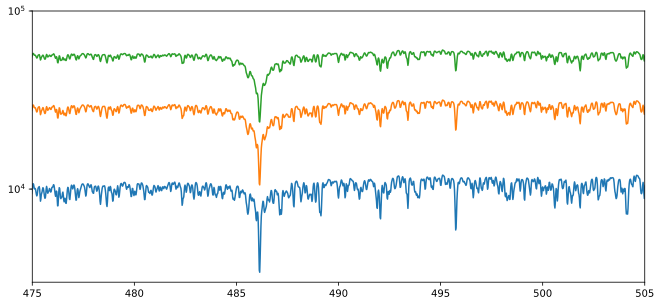

In [67]:
plt.plot(*attenuated_star_emission_with_ir_1)
plt.plot(*attenuated_star_emission_with_ir_2)
plt.plot(*attenuated_star_emission_with_ir_3)
plt.xlim(475, 505)
plt.ylim(3e3, 1e5)
# plt.xlim(95, 700)
# plt.ylim(5, 1e5)
plt.yscale('symlog')

# Convolution

In [68]:
def convolution(wavelength, flux, delta_v):

#     delta_v         = 150.0 #km/s
    c               = 3e5   #km/s 
    ELODIE_sampling = 0.02  #nm
    
    broadening_frac  = np.sqrt((delta_v*wavelength/c)**2 - (ELODIE_sampling)**2)/(2.0*np.sqrt(2.0*np.log(2.0)))
    
    dx    = float(max(wavelength) - min(wavelength))/len(wavelength)
    gx    = np.arange(-3*np.median(broadening_frac), 3*np.median(broadening_frac), dx)
    print(dx)
    gaussian  = (1.0/(np.sqrt(2.0*np.pi)*np.median(broadening_frac)))*np.exp(-(gx/np.median(broadening_frac))**2/2.0)
    convolved_flux = np.convolve(flux, gaussian, mode="same")
    convolved_flux_final = convolved_flux*dx
    
    return (convolved_flux_final)

In [69]:
attenuated_star_emission_1_convolved = convolution(attenuated_star_emission_1[0], \
                                                           attenuated_star_emission_1[1], 150)

attenuated_star_emission_2_convolved = convolution(attenuated_star_emission_2[0], \
                                                           attenuated_star_emission_2[1], 150)

attenuated_star_emission_3_convolved = convolution(attenuated_star_emission_3[0], \
                                                           attenuated_star_emission_3[1], 150)

0.019999310344827586
0.019999310344827586
0.019999310344827586


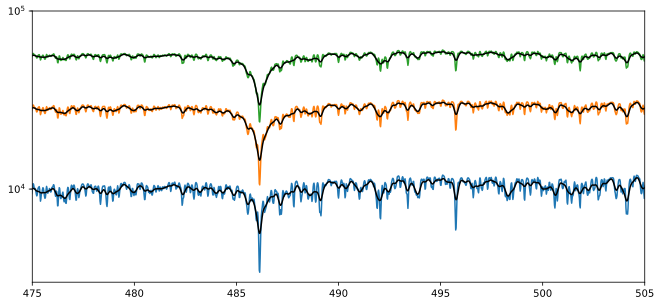

In [70]:
plt.plot(*attenuated_star_emission_with_ir_1)
plt.plot(*attenuated_star_emission_with_ir_2)
plt.plot(*attenuated_star_emission_with_ir_3)
plt.plot(attenuated_star_emission_1[0],attenuated_star_emission_1_convolved, 'k', '--')
plt.plot(attenuated_star_emission_2[0],attenuated_star_emission_2_convolved, 'k', '--')
plt.plot(attenuated_star_emission_3[0],attenuated_star_emission_3_convolved, 'k', '--')
plt.xlim(475, 505)
plt.ylim(3e3, 1e5)
# plt.xlim(95, 700)
# plt.ylim(5, 1e5)
plt.yscale('symlog')

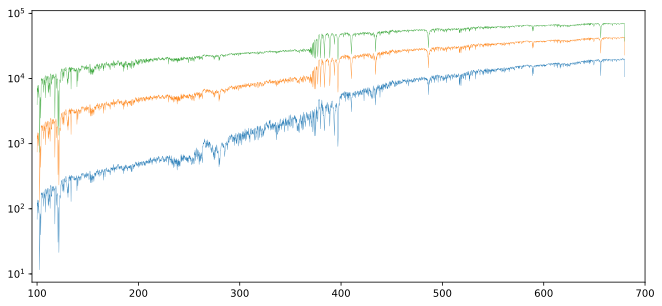

In [71]:
plt.plot(attenuated_star_emission_1[0],attenuated_star_emission_1_convolved, lw = 0.3)
plt.plot(attenuated_star_emission_2[0],attenuated_star_emission_2_convolved, lw = 0.3)
plt.plot(attenuated_star_emission_3[0],attenuated_star_emission_3_convolved, lw = 0.3)
plt.xlim(95, 700)
plt.yscale('symlog')

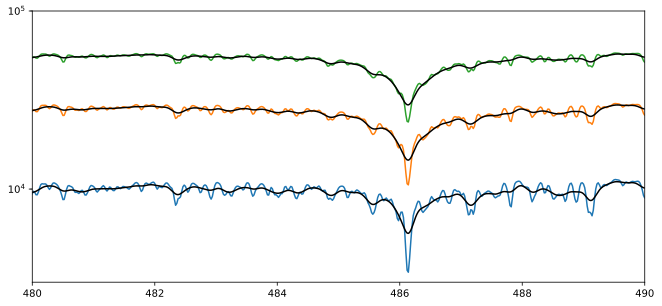

In [72]:
plt.plot(*attenuated_star_emission_with_ir_1)
plt.plot(*attenuated_star_emission_with_ir_2)
plt.plot(*attenuated_star_emission_with_ir_3)
plt.plot(attenuated_star_emission_1[0],attenuated_star_emission_1_convolved, 'k', '--')
plt.plot(attenuated_star_emission_2[0],attenuated_star_emission_2_convolved, 'k', '--')
plt.plot(attenuated_star_emission_3[0],attenuated_star_emission_3_convolved, 'k', '--')
plt.xlim(480, 490)
plt.ylim(3e3, 1e5)
# plt.xlim(95, 700)
# plt.ylim(5, 1e5)
plt.yscale('symlog')